# Introduction

In this Task we will continue to imagine that we are in a lab studying the newly sequenced Clostridioides difficile genome. After the success of the EGFP knockdown experiment we are tasked with creating a protospacer library containing 5 protospacers targeting each gene with minimal off-target effects. This will allow for a large-scale knockout screen.

In [1]:
import sys
sys.path.append('../')
import crseek
from crseek import utils
from crseek import estimators
from crseek import annotators

In [2]:
from Bio import SeqIO
from Bio.Seq import reverse_complement, BiopythonWarning
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
from scipy.stats import hmean

sbn.set(style = 'white', font_scale=1.5)
%matplotlib inline


import warnings
warnings.simplefilter('ignore', category = BiopythonWarning)


# Load sequences

Standard Biopython tools can be used to load the Thermofilum sp. NZ13-TE1 genome and the AddGene plasmid.

In [3]:
with open('data/Clostridioides_difficile_630.gb') as handle:
    genome = list(SeqIO.parse(handle, 'genbank'))[0]

# Algorithm

The `crisprtree` library allows us to use a simple algorithm.

`for each gene in C diff:`
    1. Extract possible targets
    2. Scan the genome (minus the target gene) for off-target hits
    3. Exclude high-risk protospacers
    4. Save 5 that pass the filter
    
    

In [7]:
estimator = estimators.CFDEstimator.build_pipeline()

library_grnas = []
gene_info = []

np.random.seed(0)

genome_key = genome.id + ' ' + genome.description


for feat in genome.features:
    
    if feat.type == 'CDS':
        # Only target genes
        
        #if np.random.rand() >= 0.01:
            # Only do ~1% of the genes
            # For speed reasons
        #    continue
        
        
        # Get info about this gene
        product = feat.qualifiers['product'][0]
        tag = feat.qualifiers['locus_tag'][0]
        gene_record = feat.extract(genome)
        
        # Get protospacers
        possible_targets = utils.extract_possible_targets(gene_record)
        
        # Score hits
        try:
            possible_binding = utils.cas_offinder(possible_targets, 3, locus = [genome])
        except FileNotFoundError:
            continue
        possible_binding['Score'] = estimator.predict_proba(possible_binding.values)
        
        # Set hits within the gene to be np.nan
        slic = pd.IndexSlice[genome_key, :, feat.location.start:feat.location.end ]
        possible_binding.loc[slic, 'Score'] = np.nan
        
        # Aggregate and sort off-target scan
        offtarget_scores = possible_binding.groupby('spacer')['Score'].agg('max')
        offtarget_scores.fillna(0, inplace=True) # Spacers which only have intragenic hit
        offtarget_scores.sort_values(inplace=True)
        
        # Save information
        gene_info.append({'Product': product,
                          'Tag': tag,
                          'UsefulGuides': (offtarget_scores<=0.25).sum()})
        
        
        for protospacer, off_score in offtarget_scores.head().to_dict().items():
            location = genome.seq.find(protospacer.back_transcribe())
            strand = '+'
            if location == -1:
                location = genome.seq.find(reverse_complement(protospacer.back_transcribe()))
                strand = '-'

            library_grnas.append({'Product': product,
                                  'Tag': tag,
                                  'Protospacer': protospacer,
                                  'Location': location,
                                  'Strand': strand,
                                  'Off Target Score': off_score})
            
gene_df = pd.DataFrame(gene_info)
        
library_df = pd.DataFrame(library_grnas)

# Sucess?

Our goal was to create 5 protospacers for each gene. Were we able to?

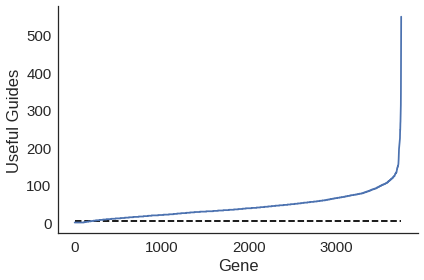

In [8]:
useful_guides = gene_df['UsefulGuides'].sort_values()
fig, ax = plt.subplots(1,1)
ax.plot(useful_guides.values)
ax.set_ylabel('Useful Guides')
ax.set_xlabel('Gene')
ax.hlines(5, 0, len(useful_guides), linestyle = '--')
sbn.despine(ax=ax)
fig.tight_layout()
fig.savefig('Task2.pdf', dpi=300)

In [9]:
len(gene_df.query('UsefulGuides > 5').index), len(gene_df.index)

(3506, 3751)

In [16]:
def get_good_spacers(df):
    
    return df.sort_values(by = 'Off Target Score').head().drop(columns = ['Product', 'Tag'])
    
good_spacers = library_df.groupby('Product').apply(get_good_spacers)

In [19]:
for _, row in good_spacers.iterrows():
    genome.features.append(annotators._build_target_feature(row['Location'], 
                                                            1 if row['Strand'] == '+' else -1, 
                                                            row['Protospacer'], 
                                                            score=row['Off Target Score']))

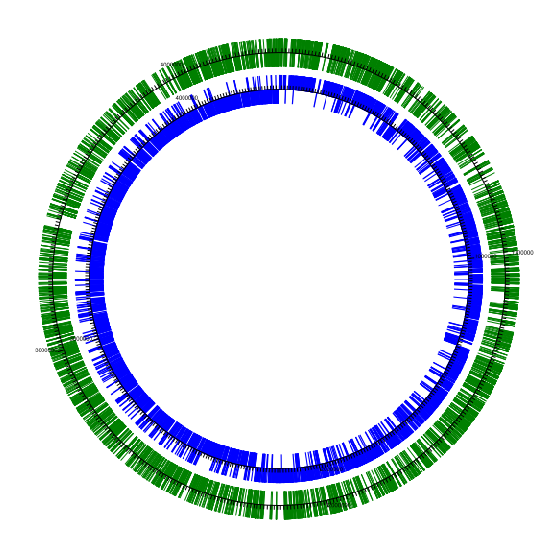

In [27]:
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO

gd_diagram = GenomeDiagram.Diagram("Clostridioides difficile 630")
gd_track_for_genes = gd_diagram.new_track(1, name="Gene Features")
gd_feature_set_for_genes = gd_track_for_genes.new_set()

gd_track_for_spacers = gd_diagram.new_track(2, name="Spacer Features")
gd_feature_set_for_spacers = gd_track_for_spacers.new_set()

for feature in genome.features:
    if feature.type == 'CDS':
        # Label genes in Blue
        color = colors.blue
        gd_feature_set_for_genes.add_feature(feature, color=color,
                                             label=False, label_size=12)
    elif 'spacer' in feature.qualifiers:
        # Label gRNAs in Green
        color = colors.green
        gd_feature_set_for_spacers.add_feature(feature, color=color,
                                             label=False, label_size=12)
        



gd_diagram.draw(format="circular",  pagesize=(20*cm,20*cm),
                fragments=4, start=0, end=len(genome), circle_core=0.7)

gd_diagram.write("genome_circular.pdf", "pdf")
gd_diagram.write("genome_circular.png", "png")

fig, ax = plt.subplots(1,1, figsize= (10, 10))

img = plt.imread("genome_circular.png")
ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])
sbn.despine(ax=ax, left=True, bottom=True)